# <div style="text-align: center; background-color:skyblue; font-family:Georgia, serif; color: black; padding: 20px;line-height: 1;border-radius:5px; border: 2px solid black;"> Clustering and Profiling of Job Positions and Companies Based on Salary Data</div>



# Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
import re
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
import warnings
warnings.filterwarnings('ignore')
import scipy.cluster.hierarchy as sch

# Load Dataset

In [43]:
df = pd.read_csv(r"https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/002/681/original/Scaler_Kmeans.csv")

In [44]:
df

,Unnamed: 0,email_hash,company,normalized_company_name,orgyear,ctc,job_position,ctc_updated_year
0,0,6de0a4417d18ab14334c3f43397fc13b30c35149d70c05...,Deloitte India,Deloitte,2016.0,1100000,Other,2020.0
1,1,b0aaf1ac138b53cb6e039ba2c3d6604a250d02d5145c10...,Reliance Infocomm Limited,Reliance Jio Infocomm Limited,2018.0,449999,FullStack Engineer,2019.0
2,2,4860c670bcd48fb96c02a4b0ae3608ae6fdd98176112e9...,Synctactic AI,NaN,2015.0,2000000,Backend Engineer,2020.0
3,3,effdede7a2e7c2af664c8a31d9346385016128d66bbc58...,Tokopedia,Tokopedia,2017.0,700000,Backend Engineer,2019.0
4,4,6ff54e709262f55cb999a1c1db8436cb2055d8f79ab520...,RIFT Group,NaN,2017.0,1400000,FullStack Engineer,2019.0
...,...,...,...,...,...,...,...,...
206918,206918,70027b728c8ee901fe979533ed94ffda97be08fc23f33b...,Apple Inc.,NaN,2008.0,220000,NaN,2019.0
206919,206919,7f7292ffad724ebbe9ca860f515245368d714c84705b42...,UpGrad.com,UpGrad.com,2017.0,500000,NaN,2020.0
206920,206920,cb25cc7304e9a24facda7f5567c7922ffc48e3d5d6018c...,Accolite,Accolite,2021.0,700000,NaN,2021.0
206921,206921,fb46a1a2752f5f652ce634f6178d0578ef6995ee59f6c8...,Not Applicable,NaN,2019.0,5100000,NaN,2019.0


# Explorartory Data Analysis

In [45]:
df.shape

(206923, 8)

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206923 entries, 0 to 206922
Data columns (total 8 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Unnamed: 0               206923 non-null  int64  
 1   email_hash               206923 non-null  object 
 2   company                  204649 non-null  object 
 3   normalized_company_name  121425 non-null  object 
 4   orgyear                  206837 non-null  float64
 5   ctc                      206923 non-null  int64  
 6   job_position             153340 non-null  object 
 7   ctc_updated_year         206923 non-null  float64
dtypes: float64(2), int64(2), object(4)
memory usage: 12.6+ MB


### Data Cleaning

In [47]:
df.isnull().sum()

Unnamed: 0                     0
email_hash                     0
company                     2274
normalized_company_name    85498
orgyear                       86
ctc                            0
job_position               53583
ctc_updated_year               0
dtype: int64

In [48]:
df['normalized_company_name'].value_counts()

normalized_company_name
Tata Consultancy Services    8748
Not Applicable               7720
Infosys                      5469
Amazon                       3529
Cognizant                    3278
                             ... 
DataArt                         1
Wabtec Corporation              1
emotix                          1
RMSI                            1
dubizzle                        1
Name: count, Length: 1154, dtype: int64

In [49]:
def normalize_company_name(name):
    # Check if the name is a string
    if isinstance(name, str):
        name = name.lower()
        # Remove common suffixes (e.g., inc., ltd., etc.)
        name = re.sub(r'\b(inc|ltd|llc|limited|corporation|corp|group)\b', '', name)
        # Remove special characters and extra spaces
        name = re.sub(r'[^a-z0-9]', ' ', name)
        name = re.sub(r'\s+', ' ', name).strip()
        return name
    else:
        # Return None or a placeholder for non-string values
        return None

# Fill null values in 'normalized_company_name' with normalized 'company' values
df['normalized_company_name'] = df['normalized_company_name'].fillna(df['company'].apply(normalize_company_name))


In [51]:
df['normalized_company_name'].value_counts()

normalized_company_name
Tata Consultancy Services        8748
Not Applicable                   7720
Infosys                          5469
Amazon                           3529
Cognizant                        3278
                                 ... 
scipl                               1
veritas symantec software pvt       1
softtek data systems                1
edcast asia pvt                     1
makemytrip ex amazon                1
Name: count, Length: 36473, dtype: int64

In [52]:
df['normalized_company_name']=df['normalized_company_name'].fillna(df['normalized_company_name'].mode().iloc[0])

In [53]:
df['company']=df['company'].fillna(df['company'].mode().iloc[0])

In [54]:
df['orgyear'].value_counts()

orgyear
2018.0    25316
2019.0    23835
2017.0    23279
2016.0    23080
2015.0    20626
          ...  
2107.0        1
1972.0        1
2101.0        1
208.0         1
200.0         1
Name: count, Length: 77, dtype: int64

In [55]:
df['orgyear'] = df['orgyear'].fillna(df['orgyear'].mode().iloc[0])

In [56]:
df['job_position'].value_counts().head()

job_position
Backend Engineer          43570
FullStack Engineer        24735
Other                     18074
Frontend Engineer         10426
Engineering Leadership     6871
Name: count, dtype: int64

In [57]:
df['job_position']=df['job_position'].fillna(df['job_position'].mode().iloc[0])

In [58]:
df.isnull().sum()

Unnamed: 0                 0
email_hash                 0
company                    0
normalized_company_name    0
orgyear                    0
ctc                        0
job_position               0
ctc_updated_year           0
dtype: int64

In [59]:
df.head()

,Unnamed: 0,email_hash,company,normalized_company_name,orgyear,ctc,job_position,ctc_updated_year
0,0,6de0a4417d18ab14334c3f43397fc13b30c35149d70c05...,Deloitte India,Deloitte,2016.0,1100000,Other,2020.0
1,1,b0aaf1ac138b53cb6e039ba2c3d6604a250d02d5145c10...,Reliance Infocomm Limited,Reliance Jio Infocomm Limited,2018.0,449999,FullStack Engineer,2019.0
2,2,4860c670bcd48fb96c02a4b0ae3608ae6fdd98176112e9...,Synctactic AI,synctactic ai,2015.0,2000000,Backend Engineer,2020.0
3,3,effdede7a2e7c2af664c8a31d9346385016128d66bbc58...,Tokopedia,Tokopedia,2017.0,700000,Backend Engineer,2019.0
4,4,6ff54e709262f55cb999a1c1db8436cb2055d8f79ab520...,RIFT Group,rift,2017.0,1400000,FullStack Engineer,2019.0


In [60]:
df.drop(columns=['Unnamed: 0','email_hash','normalized_company_name'],inplace=True)

In [61]:
df['orgyear'].value_counts()

orgyear
2018.0    25402
2019.0    23835
2017.0    23279
2016.0    23080
2015.0    20626
          ...  
2107.0        1
1972.0        1
2101.0        1
208.0         1
200.0         1
Name: count, Length: 77, dtype: int64

In [62]:
df['orgyear']=df['orgyear'].astype('int64')
df['ctc_updated_year']=df['ctc_updated_year'].astype('int64')

In [107]:
df['company'] = df['company'].apply(lambda x: re.sub('[^A-Za-z0-9 ]+', '', str(x)))
df['job_position'] = df['job_position'].apply(lambda x: re.sub('[^A-Za-z0-9 ]+', '', str(x)))


In [108]:
from datetime import datetime
current_year = datetime.now().year
current_year

2024

In [109]:

df['Year_of_experience']=current_year-df['orgyear']
df

,company,orgyear,ctc,job_position,ctc_updated_year,Year_of_experience
0,Deloitte India,2016,1100000,Other,2020,8
1,Reliance Infocomm Limited,2018,449999,FullStack Engineer,2019,6
2,Synctactic AI,2015,2000000,Backend Engineer,2020,9
3,Tokopedia,2017,700000,Backend Engineer,2019,7
4,RIFT Group,2017,1400000,FullStack Engineer,2019,7
...,...,...,...,...,...,...
206918,Apple Inc,2008,220000,Backend Engineer,2019,16
206919,UpGradcom,2017,500000,Backend Engineer,2020,7
206920,Accolite,2021,700000,Backend Engineer,2021,3
206921,Not Applicable,2019,5100000,Backend Engineer,2019,5


In [179]:
df.shape

(206879, 5)

In [67]:
df = df[df['orgyear']<2025]
df = df[df['ctc_updated_year']<2025]

In [68]:
df[df['orgyear']>2025]

,company,orgyear,ctc,job_position,ctc_updated_year


In [69]:
df.head()

,company,orgyear,ctc,job_position,ctc_updated_year
0,Deloitte India,2016,1100000,Other,2020
1,Reliance Infocomm Limited,2018,449999,FullStack Engineer,2019
2,Synctactic AI,2015,2000000,Backend Engineer,2020
3,Tokopedia,2017,700000,Backend Engineer,2019
4,RIFT Group,2017,1400000,FullStack Engineer,2019


In [70]:
df.shape

(206879, 5)

### Exploratory Data Analysis(EDA)

Text(0.5, 1.0, 'Top 10 Job Positions')

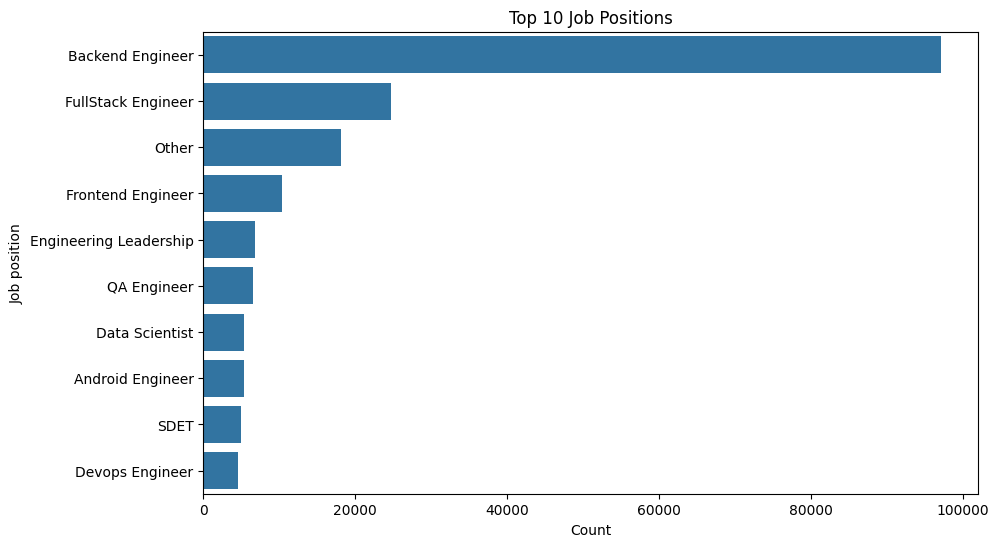

In [71]:
job_counts = df['job_position'].value_counts().reset_index()
job_counts.columns = ['job_position', 'count']

# Plot the top 10 job positions
plt.figure(figsize=(10, 6))
sns.barplot(x='count', y='job_position', data=job_counts.head(10))
plt.xlabel('Count')
plt.ylabel('Job position')
plt.title('Top 10 Job Positions')

In [72]:
company_job_counts = df.groupby('company')['job_position'].nunique().reset_index()
company_job_counts.columns = ['company', 'unique_job_positions']

top_companies = company_job_counts.sort_values(by='unique_job_positions', ascending=False).head(10)

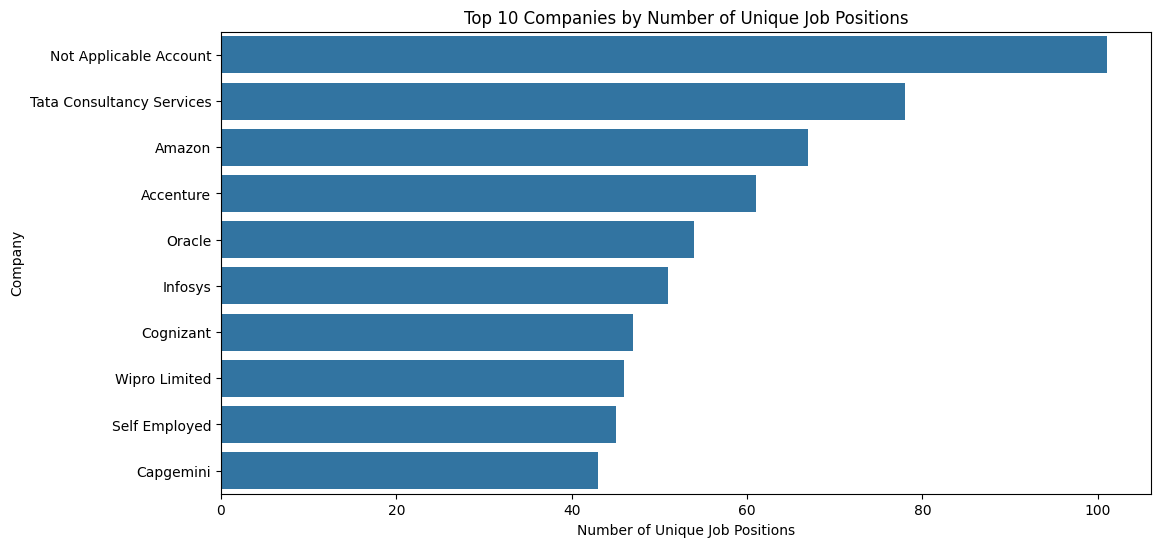

In [73]:
plt.figure(figsize=(12, 6))
sns.barplot(x='unique_job_positions', y='company', data=top_companies)
plt.xlabel('Number of Unique Job Positions')
plt.ylabel('Company')
plt.title('Top 10 Companies by Number of Unique Job Positions')
plt.show()

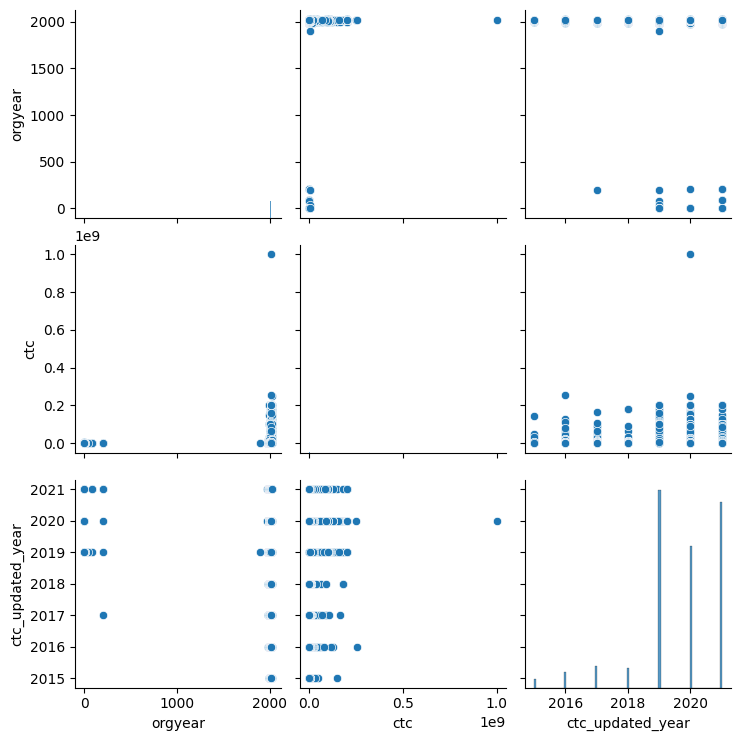

In [74]:
numeric_df = df.select_dtypes(include=['number'])
sns.pairplot(numeric_df)

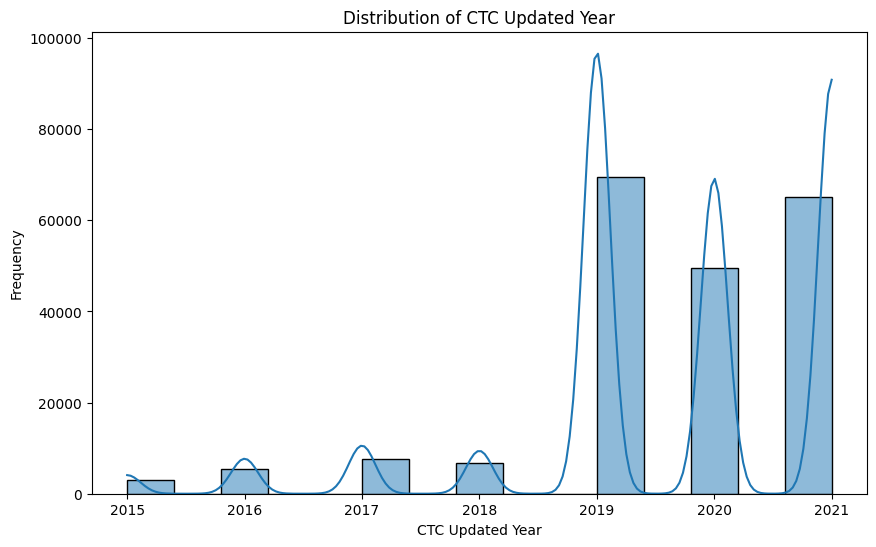

In [75]:
plt.figure(figsize=(10, 6))
sns.histplot(df['ctc_updated_year'], bins=15, kde=True)
plt.title('Distribution of CTC Updated Year')
plt.xlabel('CTC Updated Year')
plt.ylabel('Frequency')
plt.show()


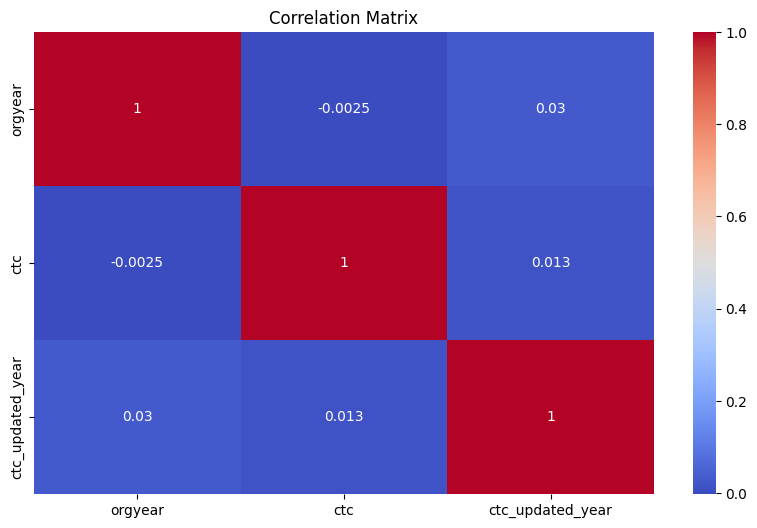

In [76]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

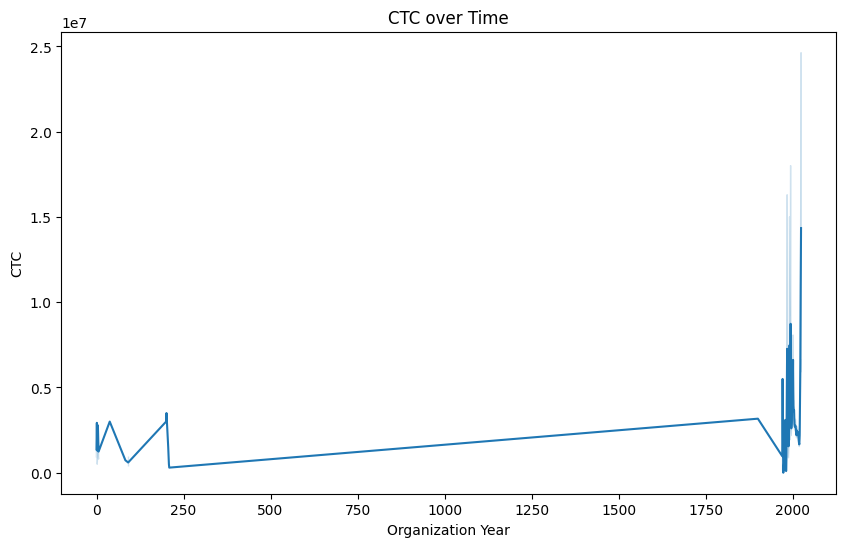

In [77]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='orgyear', y='ctc', data=df)
plt.title('CTC over Time')
plt.xlabel('Organization Year')
plt.ylabel('CTC')
plt.show()

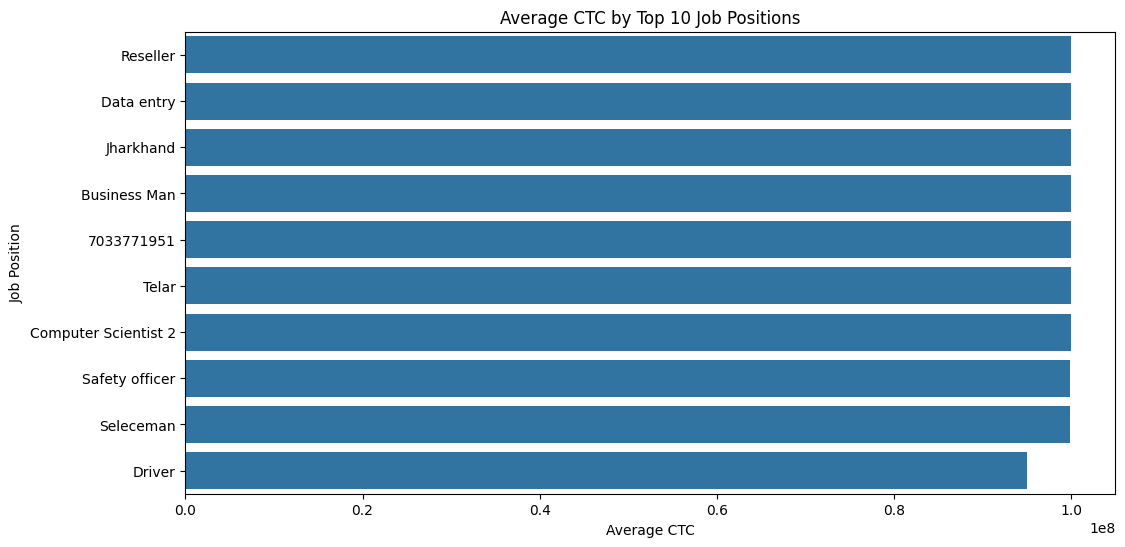

In [78]:
average_ctc_by_job = df.groupby('job_position')['ctc'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=average_ctc_by_job.values, y=average_ctc_by_job.index)
plt.title('Average CTC by Top 10 Job Positions')
plt.xlabel('Average CTC')
plt.ylabel('Job Position')
plt.show()

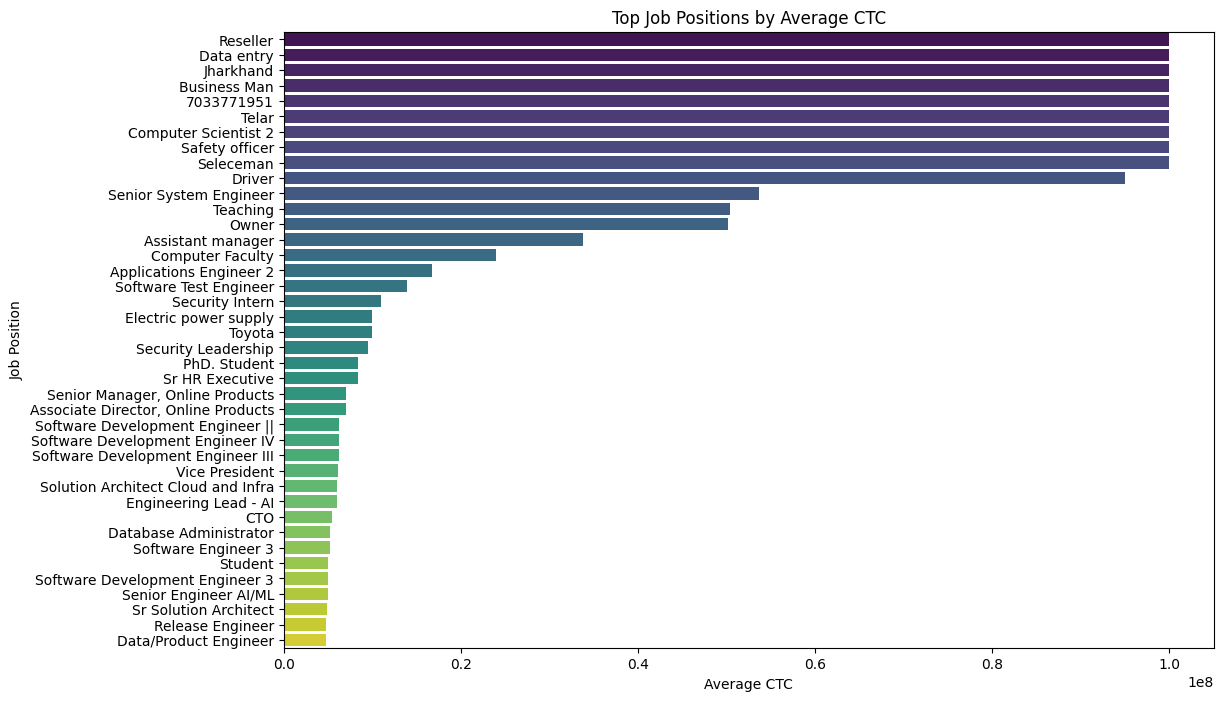

In [79]:
average_ctc_by_job = df.groupby('job_position')['ctc'].mean().sort_values(ascending=False).head(40)

plt.figure(figsize=(12, 8))
sns.barplot(x=average_ctc_by_job.values, y=average_ctc_by_job.index, palette='viridis')
plt.title('Top Job Positions by Average CTC')
plt.xlabel('Average CTC')
plt.ylabel('Job Position')
plt.show()

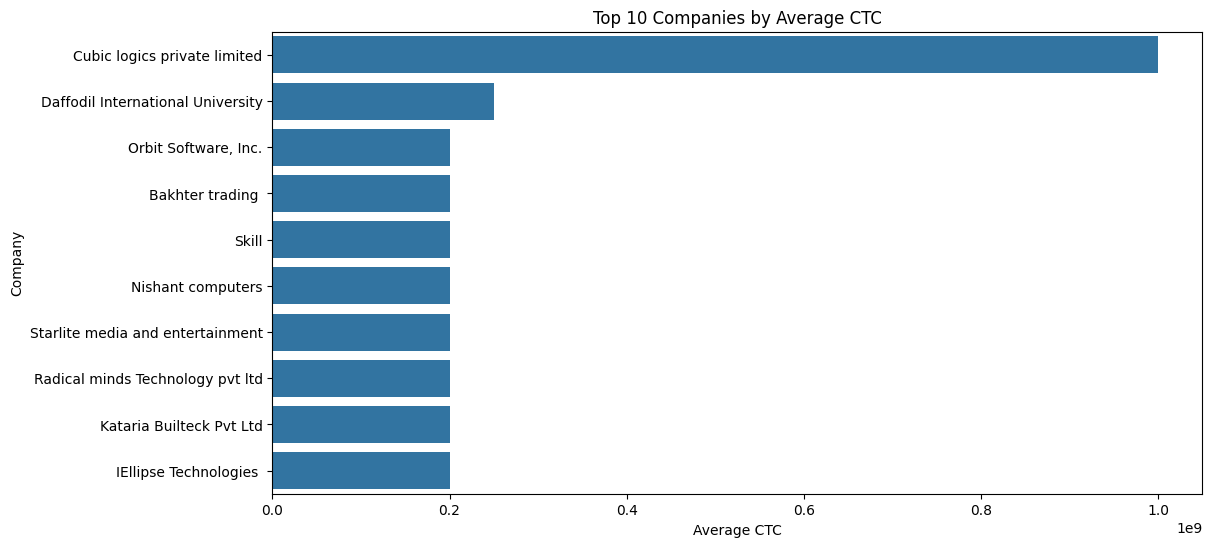

In [81]:
top_companies_ctc = df.groupby('company')['ctc'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_companies_ctc.values, y=top_companies_ctc.index)
plt.title('Top 10 Companies by Average CTC')
plt.xlabel('Average CTC')
plt.ylabel('Company')
plt.show()


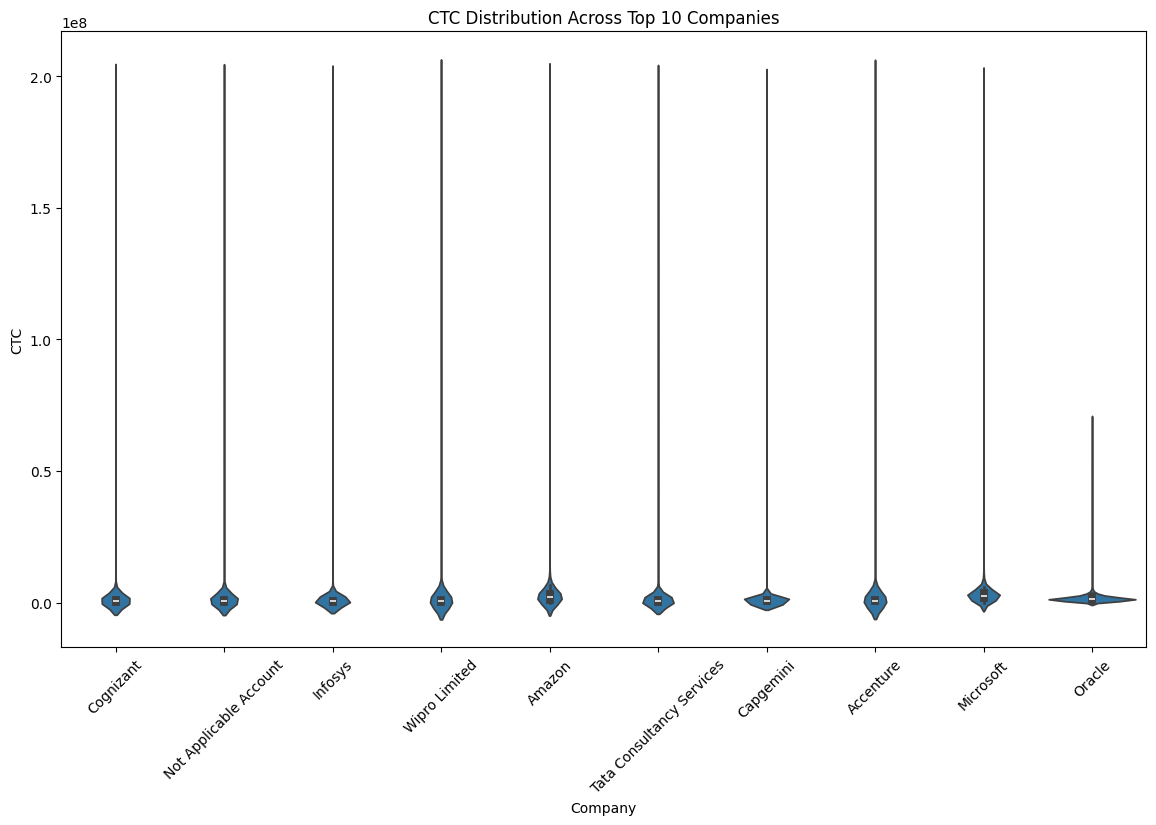

In [82]:
plt.figure(figsize=(14, 8))
top_companies = df['company'].value_counts().index[:10]  # Select top 10 companies by frequency
sns.violinplot(x='company', y='ctc', data=df[df['company'].isin(top_companies)])
plt.title('CTC Distribution Across Top 10 Companies')
plt.xlabel('Company')
plt.ylabel('CTC')
plt.xticks(rotation=45)
plt.show()

# Manual Clustering

In [122]:
company_summary = df.groupby('company')['ctc'].agg(['mean', 'median', 'max', 'min'])
company_summary



,mean,median,max,min
company,,,,
,3.958818e+06,850000.0,66600000,110000
,8.000000e+05,800000.0,800000,800000
Orange City water PVT LTD,7.000000e+07,70000000.0,70000000,70000000
Syneos health,5.500000e+05,550000.0,550000,550000
247 Customer Pvt Ltd,6.400000e+05,640000.0,640000,640000
...,...,...,...,...
zunroof tech,1.500000e+06,1500000.0,1500000,1500000
zupee,5.400000e+06,5400000.0,5400000,5400000
zuppler,1.446667e+06,1200000.0,2050000,1090000


In [123]:
job_position_summary = df.groupby('job_position')['ctc'].agg(['mean', 'median', 'max', 'min'])
job_position_summary

,mean,median,max,min
job_position,,,,
,650000.0,650000.0,700000,600000
SDE 2,1200000.0,1200000.0,1200000,1200000
7,445000.0,445000.0,470000,420000
7033771951,100000000.0,100000000.0,100000000,100000000
737,350000.0,350000.0,350000,350000
...,...,...,...,...
student,1715000.0,1715000.0,2400000,1030000
support escalation engineer,2000000.0,2000000.0,2000000,2000000
system engineer,500000.0,500000.0,500000,500000


In [125]:
df['CTC_flag'] = df.apply(lambda row: 1 if row['ctc'] > company_summary.loc[row['company']]['mean'] else 3, axis=1)


In [127]:
top_performers = df[df['CTC_flag'] == 1].head(10)
top_performers

,company,orgyear,ctc,job_position,ctc_updated_year,Year_of_experience,company_freq,job_pos_normal,CTC_flag
4,RIFT Group,2017,1400000,FullStack Engineer,2019,7,0.000029,0.119543,1
11,ToXSL Tech,2016,600000,iOS Engineer,2021,8,0.000015,0.013278,1
15,Moglix,2012,2030000,Backend Engineer,2019,12,0.000222,0.469501,1
22,Quantphi,2018,1350000,Data Scientist,2019,6,0.000019,0.025948,1
25,Times Internet,2015,9500000,Backend Engineer,2019,9,0.001547,0.469501,1
27,Capillary Technologies,2012,2200000,Frontend Engineer,2019,12,0.000498,0.050392,1
30,RIFTio,2014,2600000,Backend Engineer,2019,10,0.000019,0.469501,1
32,OATI,2013,780000,Frontend Engineer,2021,11,0.000029,0.050392,1
34,Mindtree,2011,1500000,Android Engineer,2021,13,0.002591,0.025914,1
40,Larsen Toubro,2021,2500000,Other,2020,3,0.000933,0.087326,1


# Unsupervised Clustering

In [169]:
categorical_columns = df.select_dtypes(include=['object'])
numerical_columns = df.select_dtypes(include =['int','float'])

In [129]:
df.head()

,company,orgyear,ctc,job_position,ctc_updated_year,Year_of_experience,company_freq,job_pos_normal,CTC_flag
0,Deloitte India,2016,1100000,Other,2020,8,0.000039,0.087326,3
1,Reliance Infocomm Limited,2018,449999,FullStack Engineer,2019,6,0.002064,0.119543,3
2,Synctactic AI,2015,2000000,Backend Engineer,2020,9,0.000005,0.469501,3
3,Tokopedia,2017,700000,Backend Engineer,2019,7,0.000338,0.469501,3
4,RIFT Group,2017,1400000,FullStack Engineer,2019,7,0.000029,0.119543,1


In [130]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 206879 entries, 0 to 206922
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   company             206879 non-null  object 
 1   orgyear             206879 non-null  int64  
 2   ctc                 206879 non-null  int64  
 3   job_position        206879 non-null  object 
 4   ctc_updated_year    206879 non-null  int64  
 5   Year_of_experience  206879 non-null  int64  
 6   company_freq        206879 non-null  float64
 7   job_pos_normal      206879 non-null  float64
 8   CTC_flag            206879 non-null  int64  
dtypes: float64(2), int64(5), object(2)
memory usage: 15.8+ MB


In [131]:
freq_enc = df['company'].value_counts(normalize=True)
freq_enc

company
Tata Consultancy Services    0.051866
Infosys                      0.026416
Amazon                       0.016923
Not Applicable Account       0.016488
Cognizant                    0.015782
                               ...   
cloud9                       0.000005
Utter                        0.000005
Rssquarz Tech                0.000005
darkhorse capital            0.000005
MakemyTrip Ex Amazon         0.000005
Name: proportion, Length: 40813, dtype: float64

In [132]:
df['company_freq'] = df['company'].map(freq_enc)
df

,company,orgyear,ctc,job_position,ctc_updated_year,Year_of_experience,company_freq,job_pos_normal,CTC_flag
0,Deloitte India,2016,1100000,Other,2020,8,0.000039,0.087326,3
1,Reliance Infocomm Limited,2018,449999,FullStack Engineer,2019,6,0.002064,0.119543,3
2,Synctactic AI,2015,2000000,Backend Engineer,2020,9,0.000005,0.469501,3
3,Tokopedia,2017,700000,Backend Engineer,2019,7,0.000338,0.469501,3
4,RIFT Group,2017,1400000,FullStack Engineer,2019,7,0.000029,0.119543,1
...,...,...,...,...,...,...,...,...,...
206918,Apple Inc,2008,220000,Backend Engineer,2019,16,0.000082,0.469501,3
206919,UpGradcom,2017,500000,Backend Engineer,2020,7,0.000512,0.469501,3
206920,Accolite,2021,700000,Backend Engineer,2021,3,0.000817,0.469501,3
206921,Not Applicable,2019,5100000,Backend Engineer,2019,5,0.005172,0.469501,3


In [133]:
job_freq=df['job_position'].value_counts(normalize=True)
df['job_pos_normal']=df['job_position'].map(job_freq)

In [134]:
df

,company,orgyear,ctc,job_position,ctc_updated_year,Year_of_experience,company_freq,job_pos_normal,CTC_flag
0,Deloitte India,2016,1100000,Other,2020,8,0.000039,0.087326,3
1,Reliance Infocomm Limited,2018,449999,FullStack Engineer,2019,6,0.002064,0.119543,3
2,Synctactic AI,2015,2000000,Backend Engineer,2020,9,0.000005,0.469501,3
3,Tokopedia,2017,700000,Backend Engineer,2019,7,0.000338,0.469501,3
4,RIFT Group,2017,1400000,FullStack Engineer,2019,7,0.000029,0.119543,1
...,...,...,...,...,...,...,...,...,...
206918,Apple Inc,2008,220000,Backend Engineer,2019,16,0.000082,0.469501,3
206919,UpGradcom,2017,500000,Backend Engineer,2020,7,0.000512,0.469501,3
206920,Accolite,2021,700000,Backend Engineer,2021,3,0.000817,0.469501,3
206921,Not Applicable,2019,5100000,Backend Engineer,2019,5,0.005172,0.469501,3


In [136]:
df.drop(columns=['company','orgyear','ctc_updated_year','CTC_flag','job_position'],axis=1,inplace=True)

In [137]:
df

,ctc,Year_of_experience,company_freq,job_pos_normal
0,1100000,8,0.000039,0.087326
1,449999,6,0.002064,0.119543
2,2000000,9,0.000005,0.469501
3,700000,7,0.000338,0.469501
4,1400000,7,0.000029,0.119543
...,...,...,...,...
206918,220000,16,0.000082,0.469501
206919,500000,7,0.000512,0.469501
206920,700000,3,0.000817,0.469501
206921,5100000,5,0.005172,0.469501


In [138]:
df.head()

,ctc,Year_of_experience,company_freq,job_pos_normal
0,1100000,8,0.000039,0.087326
1,449999,6,0.002064,0.119543
2,2000000,9,0.000005,0.469501
3,700000,7,0.000338,0.469501
4,1400000,7,0.000029,0.119543


In [158]:
# numerical_columns = ['', 'ctc', 'ctc_updated_year']

scaler = StandardScaler()

scaled_values = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_values, columns=df.columns)

In [159]:
scaled_df

,ctc,Year_of_experience,company_freq,job_pos_normal,Cluster
0,-0.099323,-0.044124,-0.460157,-0.783253,-0.987708
1,-0.154020,-0.113362,-0.295131,-0.628596,-0.987708
2,-0.023587,-0.009505,-0.462914,1.051376,0.659844
3,-0.132983,-0.078743,-0.435738,1.051376,0.659844
4,-0.074078,-0.078743,-0.460945,-0.628596,-0.987708
...,...,...,...,...,...
206874,-0.173375,0.232829,-0.456612,1.051376,0.659844
206875,-0.149813,-0.078743,-0.421559,1.051376,0.659844
206876,-0.132983,-0.217220,-0.396746,1.051376,0.659844
206877,0.237278,-0.147982,-0.041881,1.051376,0.659844


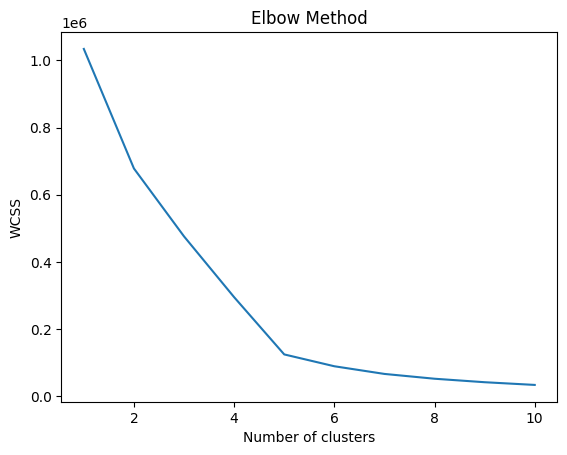

In [160]:
# Elbow Method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(scaled_df)
    wcss.append(kmeans.inertia_)

# Plot the Elbow curve
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


In [161]:
# Perform K-Means clustering
optimal_clusters = 5  # Replace with the optimal number from the Elbow method
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
df['Cluster'] = kmeans.fit_predict(scaled_df)


In [167]:
labels=kmeans.labels_

In [162]:
df

,ctc,Year_of_experience,company_freq,job_pos_normal,Cluster
0,1100000,8,0.000039,0.087326,0
1,449999,6,0.002064,0.119543,0
2,2000000,9,0.000005,0.469501,1
3,700000,7,0.000338,0.469501,1
4,1400000,7,0.000029,0.119543,0
...,...,...,...,...,...
206918,220000,16,0.000082,0.469501,1
206919,500000,7,0.000512,0.469501,1
206920,700000,3,0.000817,0.469501,1
206921,5100000,5,0.005172,0.469501,1


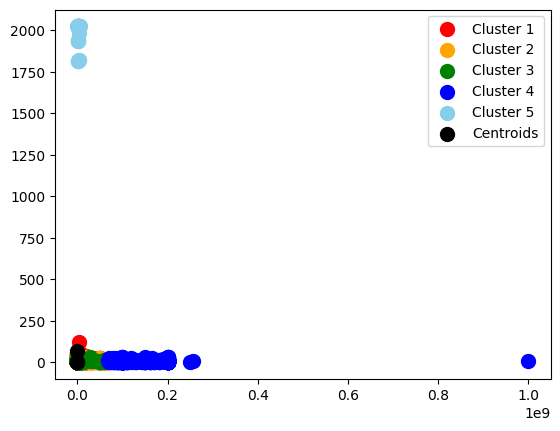

In [166]:

cluster_0_data = df[df['Cluster'] == 0]
cluster_1_data = df[df['Cluster'] == 1]
cluster_2_data = df[df['Cluster'] == 2]
cluster_3_data = df[df['Cluster'] == 3]
cluster_4_data = df[df['Cluster'] == 4]

# Use filtered data for plotting
plt.scatter(cluster_0_data.iloc[:, 0], cluster_0_data.iloc[:, 1], s=100, c='red', label='Cluster 1')
plt.scatter(cluster_1_data.iloc[:, 0], cluster_1_data.iloc[:, 1], s=100, c='orange', label='Cluster 2')
plt.scatter(cluster_2_data.iloc[:, 0], cluster_2_data.iloc[:, 1], s=100, c='green', label='Cluster 3')
plt.scatter(cluster_3_data.iloc[:, 0], cluster_3_data.iloc[:, 1], s=100, c='blue', label='Cluster 4')
plt.scatter(cluster_4_data.iloc[:, 0], cluster_4_data.iloc[:, 1], s=100, c='skyblue', label='Cluster 5')
#Plotting the centroids of the clusters
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:,1], s = 100, c = 'black', label = 'Centroids');

plt.legend()
plt.show()

In [168]:
from sklearn.metrics import silhouette_score

# Assuming X is your data and labels are your cluster assignments
score = silhouette_score(scaled_df, labels)
print(f'Silhouette Score: {score}')


Silhouette Score: 0.7589668533684596


# Using PCA

In [170]:
from sklearn.decomposition import PCA


In [171]:
# Initialize PCA
pca = PCA()

# Fit PCA on the standardized data
X_pca = pca.fit_transform(scaled_df)

# Check the explained variance ratio
explained_variance = pca.explained_variance_ratio_
print("Explained variance ratio:", explained_variance)


Explained variance ratio: [0.40262869 0.20014126 0.19993412 0.18655346 0.01074247]


In [175]:
# Choose the number of principal components
num_components = 2 

# Refit PCA with the chosen number of components
pca = PCA(n_components=num_components)
X_pca = pca.fit_transform(scaled_df)


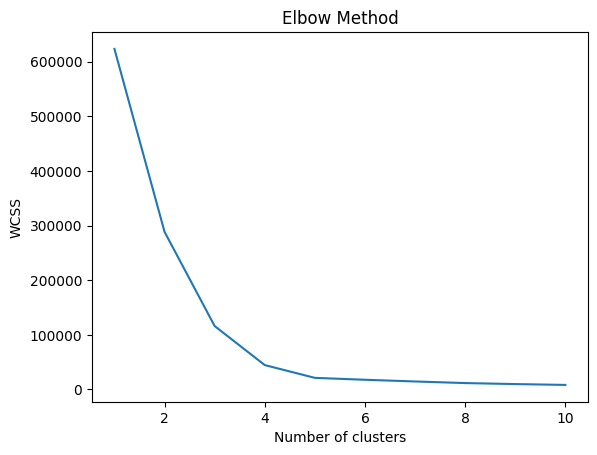

In [173]:
# Determine the number of clusters using the Elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_pca)
    wcss.append(kmeans.inertia_)

# Plot the Elbow curve
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()



In [176]:
# Perform K-Means clustering
optimal_clusters = 5  # Replace with the optimal number from the Elbow method
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
df['Cluster'] = kmeans.fit_predict(X_pca)

In [177]:
labels=kmeans.labels_

Cluster Centers:
          PC1        PC2
0  -0.810303  -0.022863
1  -2.725379   9.867333
2   0.519814  -0.151179
3 -25.950843 -31.496838
4   2.394800   0.358243
Cluster Distribution:
 Cluster
2    96437
0    95626
4    13424
1     1349
3       43
Name: count, dtype: int64


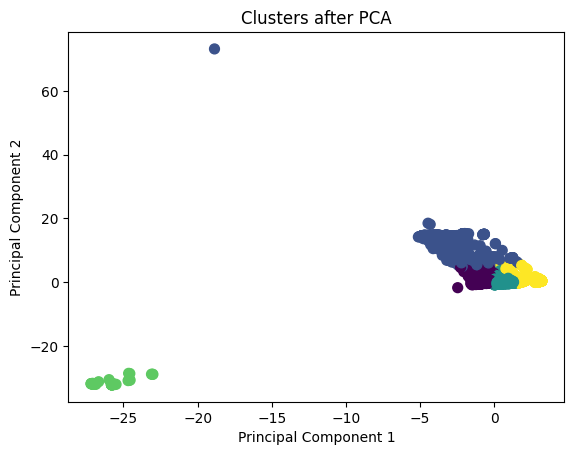

In [156]:
# Cluster Centers
cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=[f'PC{i+1}' for i in range(num_components)])
print("Cluster Centers:\n", cluster_centers)

# Cluster Distribution
cluster_distribution = df['Cluster'].value_counts()
print("Cluster Distribution:\n", cluster_distribution)

# Visualize clusters
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['Cluster'], s=50, cmap='viridis')
plt.title('Clusters after PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


In [178]:
from sklearn.metrics import silhouette_score

# Assuming X is your data and labels are your cluster assignments
score = silhouette_score(X_pca, labels)
print(f'Silhouette Score: {score}')

Silhouette Score: 0.8551885771182699
